### MF Outline
1. Load in the data
2. Initialize W, B, U, c, mu
3. Implement training algo, iterate until loss converge
4. Plot the train/test MSE per iteration to know converge
5. Print the final train/test MSE

Check the **mf.py** for clean code.


<img src="images/mf_equ.png" alt="score" width="400" height="200">

In [2]:
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from datetime import datetime

In [3]:
# load in the data
import os 
data_path = "../processed_movielens_data/"

with open(data_path + 'user2movie.json', 'rb') as f:
    user2movie = pickle.load(f)

with open(data_path + 'movie2user.json', 'rb') as f:
    movie2user = pickle.load(f)

with open(data_path + 'usermovie2rating.json', 'rb') as f:
    usermovie2rating = pickle.load(f)

with open(data_path + 'usermovie2rating_test.json', 'rb') as f:
    usermovie2rating_test = pickle.load(f)


In [4]:
N = np.max(list(user2movie.keys()))+1
# The test set may contain movises the train set does not have data on
m1 = np.max(list(movie2user.keys()))
m2 = np.max([m for (u, m), r in usermovie2rating_test.items()])
M = max(m1, m2) + 1
print("N:", N, "M:", M)


N: 10000 M: 2000


#### Initialize variables

In [5]:
K = 10 # latent dimensionality
W = np.random.randn(N, K)
b = np.zeros(N) # user bias
U = np.random.randn(M, K)
c = np.zeros(M) # movie bias
mu = np.mean((list(usermovie2rating.values()))) # global average

#### predict[i, j] = W[i].dot(U[j]) + b[i] + c.T[j] + mu

In [15]:
def get_loss(d: dict):
    # d: (user_id, movie_id) -> rating
    N = float(len(d)) # num of ratings
    sse = 0
    for k, rating in d.items():
        i, j = k # i is user id, j is movie id
        pred = W[i].dot(U[j]) + b[i] + c[j] + mu
        sse += (pred - rating) * (pred - rating)
    return sse/N

### train the parameters
#### Update W and b; U and c

In [24]:
epochs = 25
reg = 20.0 # regularization penalty
train_losses = []
test_losses = []

for epoch in range(epochs):
    print('epoch: ', epoch)
    epoch_start = datetime.now()
    
    ###### update W and b ######
    t0 = datetime.now()
    # loop through each user
    for i in range(N): 
        ### for W
        matrix = np.eye(K) * reg # (K,K)
        vector = np.zeros(K) #(K,1)
        
        #### for b
        bi = 0
        # loop through each movie j that user i has rated
        for j in user2movie[i]:
            r = usermovie2rating[(i,j)]
            matrix += np.outer(U[j], U[j]) #U[j](K,1) outer->(K,K)
            vector += (r - b[i] - c[j] - mu)*U[j] # (K,1)
            bi += (r - W[i].dot(U[j]) - c[j] - mu)
        
        # set the update
        W[i] = np.linalg.solve(matrix, vector) # solve Ax = b, find x
        b[i] = bi / (len(user2movie[i]) + reg)
        
        if i % (N//10) == 0:
            print("i: ", i, "N: ", N)
    print("Updated W and b: ", datetime.now() - t0)
    
    ###### update U and c #####
    t0 = datetime.now()
    for j in range(M):
        # for U
        matrix = np.eye(K) * reg
        vector = np.zeros(K)

        # for c
        cj = 0
        try:
          for i in movie2user[j]:
            r = usermovie2rating[(i,j)]
            matrix += np.outer(W[i], W[i])
            vector += (r - b[i] - c[j] - mu)*W[i]
            cj += (r - W[i].dot(U[j]) - b[i] - mu)

          # set the updates
          U[j] = np.linalg.solve(matrix, vector)
          c[j] = cj / (len(movie2user[j]) + reg)

          if j % (M//10) == 0:
            print("j:", j, "M:", M)
        except KeyError:
          # possible not to have any ratings for a movie
          pass
    print("updated U and c:", datetime.now() - t0)
    print("epoch duration:", datetime.now() - epoch_start)
    
    # store train loss
    t0 = datetime.now()
    train_losses.append(get_loss(usermovie2rating))

    # store test loss
    test_losses.append(get_loss(usermovie2rating_test))
    print("calculate cost:", datetime.now() - t0)
    print("train loss:", train_losses[-1])
    print("test loss:", test_losses[-1])

print("train losses:", train_losses)
print("test losses:", test_losses)

epoch:  0
i:  0 N:  10000
i:  1000 N:  10000
i:  2000 N:  10000
i:  3000 N:  10000
i:  4000 N:  10000
i:  5000 N:  10000
i:  6000 N:  10000
i:  7000 N:  10000
i:  8000 N:  10000
i:  9000 N:  10000
Updated W and b:  0:00:54.808416
j: 0 M: 2000
j: 200 M: 2000
j: 400 M: 2000
j: 600 M: 2000
j: 800 M: 2000
j: 1000 M: 2000
j: 1200 M: 2000
j: 1400 M: 2000
j: 1600 M: 2000
j: 1800 M: 2000
updated U and c: 0:00:56.861083
epoch duration: 0:01:51.669797
calculate cost: 0:00:07.952133
train loss: 0.5654854547039344
test loss: 0.5957257444573116
epoch:  1
i:  0 N:  10000
i:  1000 N:  10000
i:  2000 N:  10000
i:  3000 N:  10000
i:  4000 N:  10000
i:  5000 N:  10000
i:  6000 N:  10000
i:  7000 N:  10000
i:  8000 N:  10000
i:  9000 N:  10000
Updated W and b:  0:00:56.336629
j: 0 M: 2000
j: 200 M: 2000
j: 400 M: 2000
j: 600 M: 2000
j: 800 M: 2000
j: 1000 M: 2000
j: 1200 M: 2000
j: 1400 M: 2000
j: 1600 M: 2000
j: 1800 M: 2000
updated U and c: 0:00:55.568783
epoch duration: 0:01:51.905740
calculate cost: 

i:  7000 N:  10000
i:  8000 N:  10000
i:  9000 N:  10000
Updated W and b:  0:00:56.322188
j: 0 M: 2000
j: 200 M: 2000
j: 400 M: 2000
j: 600 M: 2000
j: 800 M: 2000
j: 1000 M: 2000
j: 1200 M: 2000
j: 1400 M: 2000
j: 1600 M: 2000
j: 1800 M: 2000
updated U and c: 0:00:55.476620
epoch duration: 0:01:51.799317
calculate cost: 0:00:07.624591
train loss: 0.50989168933704
test loss: 0.5420280383836995
epoch:  16
i:  0 N:  10000
i:  1000 N:  10000
i:  2000 N:  10000
i:  3000 N:  10000
i:  4000 N:  10000
i:  5000 N:  10000
i:  6000 N:  10000
i:  7000 N:  10000
i:  8000 N:  10000
i:  9000 N:  10000
Updated W and b:  0:00:56.506207
j: 0 M: 2000
j: 200 M: 2000
j: 400 M: 2000
j: 600 M: 2000
j: 800 M: 2000
j: 1000 M: 2000
j: 1200 M: 2000
j: 1400 M: 2000
j: 1600 M: 2000
j: 1800 M: 2000
updated U and c: 0:00:55.541582
epoch duration: 0:01:52.048054
calculate cost: 0:00:07.614891
train loss: 0.5098320321641654
test loss: 0.5419567422235896
epoch:  17
i:  0 N:  10000
i:  1000 N:  10000
i:  2000 N:  10000


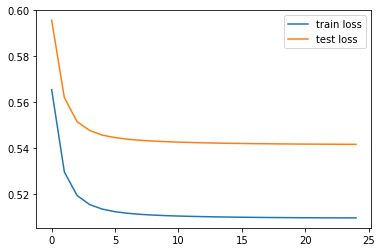

In [25]:
# plot losses
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()

In [8]:
np.zeros(K).shape

(10,)

In [10]:
U[0].shape

(10,)

In [11]:
np.outer(U[0], U[0]).shape

(10, 10)